# World demographics analysis with the CIA factbook

This short project answers a few world demographics questions using data taken from the [CIA world factbook](https://www.cia.gov/library/publications/the-world-factbook/). The data is saved as a SQL database which we will manage using a Python library for SQLite.  

Questions answered in this project are:
* Which countries have the lowest and highest populations?
* Which countries have the lowest and highest population growth?
* What are the disbributions of birth rates and death rates for all countries?
* Which countries have the highest population densities?
* Which countries have the highest water to land ratio?


In [21]:
import pandas as pd
import sqlite3

# Connect to database from the CIA factbook
conn = sqlite3.connect('factbook.db')

# Print the first 5 rows of the "facts" table
query = "SELECT * FROM facts"
pd.read_sql_query(query, conn).head()


,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230.0,652230.0,0.0,32564342.0,2.32,38.57,13.89,1.51
1,2,al,Albania,28748.0,27398.0,1350.0,3029278.0,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741.0,2381741.0,0.0,39542166.0,1.84,23.67,4.31,0.92
3,4,an,Andorra,468.0,468.0,0.0,85580.0,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700.0,1246700.0,0.0,19625353.0,2.78,38.78,11.49,0.46


We can start by looking at outlier countries. Let's look at :  
* Min/max population
* Min/max population growth

In [20]:
# Query minimum population from database
query = "SELECT MIN(population) FROM facts"
print('Min. pop.:', pd.read_sql_query(query, conn).iloc[0,0])

# Query maximum population from database
query = "SELECT MAX(population) FROM facts"
print('Max. pop.:', pd.read_sql_query(query, conn).iloc[0,0])

# Query minimum population growth from database
query = "SELECT MIN(population_growth) FROM facts"
print('Min. pop. growth:', pd.read_sql_query(query, conn).iloc[0,0], '%')

# Query maximum population growth from database
query = "SELECT MAX(population_growth) FROM facts"
print('Max. pop. growth:', pd.read_sql_query(query, conn).iloc[0,0], '%')

Min. pop.: 0
Max. pop.: 7256490011
Min. pop. growth: 0.0 %
Max. pop. growth: 4.02 %


There is a country with a population of zero. This needs to be investigated. Also, a country with 7 billion habitants is no possible - this is close to the world population.

In [31]:
# Query country with the minimum population
query = "SELECT name, population FROM facts " + \
        "WHERE population=0 "
pd.read_sql_query(query, conn)

,name,population
0,Antarctica,0


Checks out. Antartica hosts a few scientists but there are no indigenous residents. Now, which country was the one with highest population?

In [32]:
# Query country with the maximum population
query = "SELECT name, population FROM facts " + \
        "WHERE population=7256490011 "
pd.read_sql_query(query, conn)

,name,population
0,World,7256490011


World is also a row of this database, which is why the population was so high. So we need to look at the row with the second highest population.

In [38]:
# Query highest population countries
query = "SELECT name, population FROM facts " + \
        "ORDER BY population DESC " + \
        "LIMIT 3"
pd.read_sql_query(query, conn)

,name,population
0,World,7256490011
1,China,1367485388
2,India,1251695584


China is the country with highest population, seconded by India.

In the next step, we want to plot histograms of population, population growth, birth rate and death rate for countries.

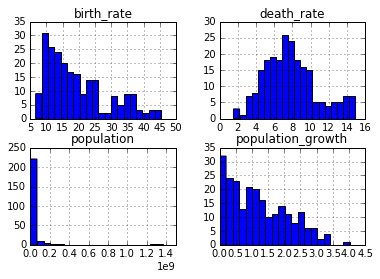

In [59]:
# Build dataframe
query = "SELECT population, population_growth, birth_rate, death_rate FROM facts " + \
        "WHERE name!='World' AND name!='Antartica' AND name!='European Union'"
df = pd.read_sql_query(query, conn)

# Build histograms
import matplotlib.pyplot as plt
%matplotlib inline
axes = df.hist(bins=20, layout=(2,2))
axes[1,0].set_xlim(0, 1.5e9)
plt.show()

The birth rate is really skewed towards high birth dates, with the death rate approximately follows a Bell curve. High population countries are really rare compared to countries with populations below ~100e6. Because birth rates are generally higher than death rates (eyeballing averages of 15% vs 7%), population growth is almost exclusively positive.

In the next question, we ask which countries have the highest population density.

In [61]:
# Query highest population density countries
query = "SELECT name, population/area_land AS population_density FROM facts " + \
        "ORDER BY population_density DESC " + \
        "LIMIT 5"
pd.read_sql_query(query, conn)

,name,population_density
0,Macau,21168
1,Monaco,15267
2,Singapore,8259
3,Hong Kong,6655
4,Gaza Strip,5191


We can then visualize the population density from all countries in a histogram: 

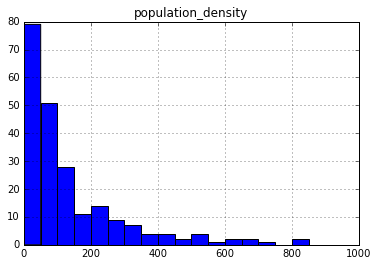

In [73]:
# Query highest population density countries
query = "SELECT name, population/area_land AS population_density FROM facts " + \
        "ORDER BY population_density DESC "
df = pd.read_sql_query(query, conn)

# Plot histogram
ax = df.hist(bins=20, range=(0,1000))

Most countries have population densities below 50 persons per km^2. 

In the following set of questions, we ask: 
* Which countries have the highest ratios of water to land? 
* Which countries have more water than land?

In [87]:
# Query highest water to land ratio countries
query = "SELECT name, cast(area_water as float)/area_land as ratio FROM facts " + \
        "ORDER BY ratio DESC " + \
        "LIMIT 5"
print('5 top countries with highest ratio of water to land')
print(pd.read_sql_query(query, conn))

# Query countries with more water than land
query = "SELECT name, cast(area_water as float)/cast(area_land as float) as ratio FROM facts " + \
        "WHERE ratio>0.5 " + \
        "ORDER BY ratio DESC "
print('\n\nCountries with more water than land')
print(pd.read_sql_query(query, conn))

5 top countries with highest ratio of water to land
                             name       ratio
0  British Indian Ocean Territory  905.666667
1                  Virgin Islands    4.520231
2                     Puerto Rico    0.554791
3                    Bahamas, The    0.386613
4                   Guinea-Bissau    0.284673


Countries with more water than land
                             name       ratio
0  British Indian Ocean Territory  905.666667
1                  Virgin Islands    4.520231
2                     Puerto Rico    0.554791


The most surprising result here is the British Indian Ocean Territory, with a water to land area ratio of 900! This actually consists of very small islands and a lot of ocean, explaining the ratio.

# Conclusion

In this notebook, we used data taken from the [CIA world factbook](https://www.cia.gov/library/publications/the-world-factbook/) to answer world demographics questions. We learned that the lowest population country is Antartica, and the highest population country is China, closely seconded by India. The vast majority of countries have populations below 100e6. We observed that the birth rate is really skewed towards high birth dates, with the death rate approximately follows a Bell curve. The three countries with the highest population densities are Macau, Monaco, and Singapore. Finally, the only three countries with more water than land are British Indian Ocean Territory, ?

